# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

from utils import mean_std_cross_val_scores, plot_roc_curve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import shuffle
from xgboost import XGBClassifier, XGBRegressor

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# 1. Data Preparation

In [2]:
df = pd.read_csv("../data/processed/labeled_data_RG3.csv", parse_dates=True)
df.set_index("TimeStamp", inplace=True)

In [3]:
df.head()

,_id,Filling_Time,Barrel_Temperature_2,Max_Injection_Pressure,Barrel_Temperature_4,Cushion_Position,Barrel_Temperature_5,Mold_Temperature_4,Injection_Time,Max_Injection_Speed,...,Barrel_Temperature_1,Barrel_Temperature_6,Reason,Max_Switch_Over_Pressure,Cycle_Time,PassOrFail,Max_Back_Pressure,Plasticizing_Time,Max_Screw_RPM,Clamp_Close_Time
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2020-10-21 00:57:37,5f8f87c09c0189cc6679187a,0.93,285.000000,142.300003,275.399994,654.289978,265.100006,22.5,1.06,128.500000,...,286.000000,234.899994,None,115.699997,61.779999,0,55.599998,13.01,30.9,6.81
2020-10-21 00:57:37,5f8f87c09c0189cc6679187d,0.93,285.000000,142.300003,275.399994,654.289978,265.100006,22.5,1.06,128.500000,...,286.000000,234.899994,None,115.699997,61.779999,0,55.599998,13.01,30.9,6.81
2020-10-21 00:56:34,5f8f87c09c0189cc66791885,0.93,285.799988,142.399994,275.600006,654.280029,265.600006,22.5,1.06,128.500000,...,286.200012,234.800003,None,115.800003,61.779999,0,55.700001,12.99,30.9,6.81
2020-10-21 00:56:34,5f8f87c19c0189cc66791888,0.93,285.799988,142.399994,275.600006,654.280029,265.600006,22.5,1.06,128.500000,...,286.200012,234.800003,None,115.800003,61.779999,0,55.700001,12.99,30.9,6.81
2020-10-21 00:55:34,5f8f87c29c0189cc6679188e,0.93,285.100006,142.500000,276.000000,654.270020,265.100006,22.5,1.06,128.399994,...,286.500000,234.699997,None,116.000000,61.759998,0,55.799999,12.95,30.9,6.81


In [4]:
numerical_features = [x for x in df.columns if np.dtype(df[x]) == "float64"]
target = ["PassOrFail"]
drop_features = set(list(df.columns)) - set(numerical_features) - set(target)

In [5]:
X = df[numerical_features]
y = df["PassOrFail"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# 2. Machine Learning

In [7]:
results = {}

## 2.1. Baseline Model

In [8]:
pipe_dummy = make_pipeline(StandardScaler(), DummyClassifier())

In [9]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True, scoring="f1"
)

In [10]:
pd.DataFrame(results)

,Dummy
fit_time,0.003 (+/- 0.000)
score_time,0.002 (+/- 0.000)
test_score,0.000 (+/- 0.000)
train_score,0.000 (+/- 0.000)


## 2.2. ML Models

#### 2.2.1. Cross-Validation

In [11]:
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=123))
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=123))
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=123, probability=True))
pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(StandardScaler(), XGBClassifier(random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(StandardScaler(), LGBMClassifier(random_state=123))
pipe_catb = make_pipeline(
    StandardScaler(), CatBoostClassifier(random_state=123, verbose=0)
)

In [12]:
models = {
    "decision_tree": pipe_dt,
    "logistic_regression": pipe_lr,
    "SVC": pipe_svc,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [13]:
for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring="f1"
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.74s/it]


In [14]:
pd.DataFrame(results)

,Dummy,decision_tree,logistic_regression,SVC,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.003 (+/- 0.000),0.006 (+/- 0.001),0.011 (+/- 0.004),0.033 (+/- 0.004),0.156 (+/- 0.007),0.298 (+/- 0.508),0.074 (+/- 0.016),1.759 (+/- 0.092)
score_time,0.002 (+/- 0.000),0.002 (+/- 0.000),0.002 (+/- 0.000),0.005 (+/- 0.001),0.011 (+/- 0.001),0.007 (+/- 0.001),0.005 (+/- 0.000),0.004 (+/- 0.000)
test_score,0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
train_score,0.000 (+/- 0.000),0.640 (+/- 0.097),0.000 (+/- 0.000),0.000 (+/- 0.000),0.644 (+/- 0.099),0.640 (+/- 0.097),0.644 (+/- 0.099),0.558 (+/- 0.139)


#### 2.2.2. Confusion Matrix & Classification Report

In [15]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Confusion Matrix for {name}")
    print(confusion_matrix(y_test, y_pred))
    print("\n")
    print(f"Classification Report for {name}")
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------")

Confusion Matrix for decision_tree
[[357  10]
 [  9   1]]


Classification Report for decision_tree
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       367
           1       0.09      0.10      0.10        10

    accuracy                           0.95       377
   macro avg       0.53      0.54      0.53       377
weighted avg       0.95      0.95      0.95       377

-----------------------------------------------------
Confusion Matrix for logistic_regression
[[367   0]
 [ 10   0]]


Classification Report for logistic_regression
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       367
           1       0.00      0.00      0.00        10

    accuracy                           0.97       377
   macro avg       0.49      0.50      0.49       377
weighted avg       0.95      0.97      0.96       377

-----------------------------------------------------
Confusion Matrix for SVC
[

#### 2.2.3. ROC Curve

ROC Curve for decision_tree


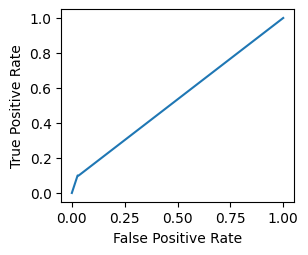

f1 score of decision_tree : 0.1
-----------------------------------------------------
ROC Curve for logistic_regression


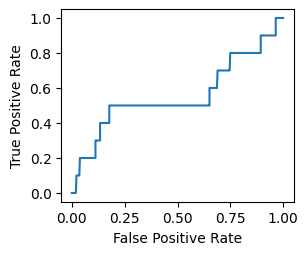

f1 score of logistic_regression : 0.0
-----------------------------------------------------
ROC Curve for SVC


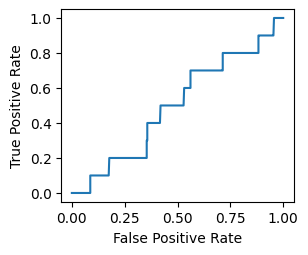

f1 score of SVC : 0.0
-----------------------------------------------------
ROC Curve for random_forest


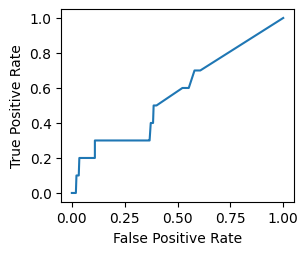

f1 score of random_forest : 0.0
-----------------------------------------------------
ROC Curve for XGBoost


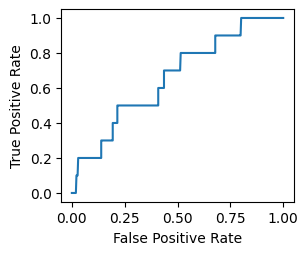

f1 score of XGBoost : 0.0
-----------------------------------------------------
ROC Curve for LightGBM


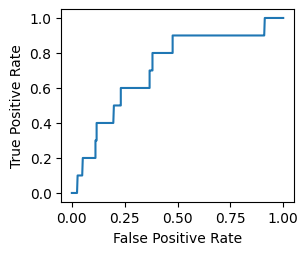

f1 score of LightGBM : 0.0
-----------------------------------------------------
ROC Curve for CatBoost


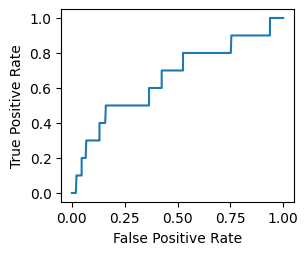

f1 score of CatBoost : 0.0
-----------------------------------------------------


In [16]:
for name, model in models.items():
    print(f"ROC Curve for {name}")
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    plot_roc_curve(y_test, y_prob[:, 1])
    f1 = f1_score(y_test, y_pred)
    print(f"f1 score of {name} : {np.round(f1, 2)}")
    print("-----------------------------------------------------")

# 3. Test Summary

- All of Cross-validation, confusion matrix, and ROC curves show that it was impossible to classify the defects from the data by using the machine learning models for `RG3`.